# **ISIC 2016 Challenge - Lesion Segmentation**

**Mario Lozano Cortés - Universitat de Barcelona - Universitat Politècnica De Catalunya · Barcelona Tech**

**The overarching goal of this challenge is to develop image analysis tools to enable the automated diagnosis of melanoma from dermoscopic images.** Skin cancer is a major public health problem, with over 5,000,000 newly diagnosed cases in the United States every year. Melanoma is the deadliest form of skin cancer, responsible for an overwhelming majority of skin cancer deaths. In 2015, the global incidence of melanoma was estimated to be over 350,000 cases, with almost 60,000 deaths. Although the mortality is significant, when detected early, melanoma survival exceeds 95%.

The training data file contains **900 dermoscopic lesion images** in JPEG format, along with the corresponding segmentation mask.

Segmentations will be compared using a variety of metrics, all computed at the level of single pixels, including: sensitivity, specificity, accuracy, **Jaccard index**, Dice coefficient and Roc curve, being Jaccard index the reference one.

The exercise will be completed in **Keras**, building an **U-Net-like architecture**.

**Throughout this notebook you will find comments and explanations of what is being done at any given moment. However, the final discussion of the results is detailed in the section *Results, critical commentary and discussion* at the end of this notebook. It is strongly recommended to consult all the explanatory texts.**

# **Imports and variable declarations**

This section contains the libraries used in the notebook as well as the variables relating to the parameters of the generated network.

In [11]:
import os # os functionalities
import random # generation of random numbers
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
from sklearn import metrics # create ROC curve
from matplotlib import pyplot as plt # image visualization

# Tensorflow & Keras
import warnings
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
warnings.filterwarnings('ignore')
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img

# Image manipulation
from skimage import io
from PIL import Image, ImageOps
from IPython.display import Image, display

In [12]:
# Variable declaration
input_dir = "../input/isic-2016-challenge-lesion-segmentation/ISBI2016_ISIC_Part1_Training_Data/ISBI2016_ISIC_Part1_Training_Data"
target_dir = "../input/isic-2016-challenge-lesion-segmentation/ISBI2016_ISIC_Part1_Training_GroundTruth/ISBI2016_ISIC_Part1_Training_GroundTruth"

epochs = 20
batch_size = 16
img_size = (160,160)
learning_rate = 0.001
optimizer = "RMSprop"
data_augmentation = False
loss_function = "sparse_categorical_crossentropy"
num_classes = 2 # 0 - 1 / lesion - no lesion

# Percentages of images going to train - val - test sets
percentage_test = 0.05
percentage_validation = 0.12

# **Data loading**

The 900 images are located in a folder called *Training Data*. On the other hand, the segmentations of the images are in another folder called *Ground Truth*.

In [13]:
# Get paths to the training and target images
input_img_paths = sorted([
    os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")])

target_img_paths = sorted([
    os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")])

# Check if dimentions are equal
print("Number of samples in the training set:", len(input_img_paths))
print("Number of samples in the target set:", len(target_img_paths))

Number of samples in the training set: 900
Number of samples in the target set: 900


# **Data visualization**

An image of the dataset with its corresponding segmentation is shown to visually check what the dataset looks like.

The shape of the pictures in the training set is: (768, 1024, 3)
The shape of the pictures in the target set is: (768, 1024)


Text(0.5, 1.0, 'Segmentation mask')

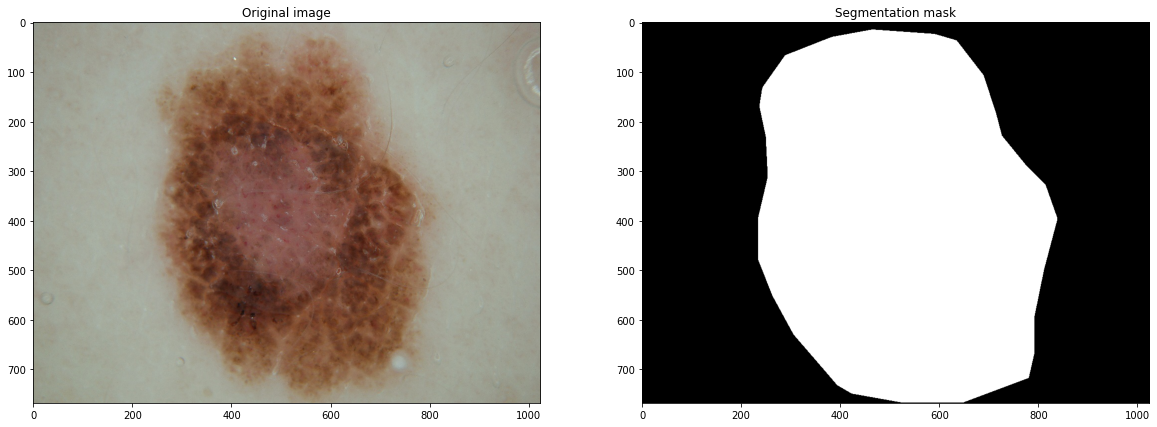

In [14]:
# Read training images and get their shape
image_to_visualize = 500
img1 = io.imread(input_img_paths[image_to_visualize])
img_shape = np.shape(img1)
print(f"The shape of the pictures in the training set is: {img_shape}")

# Read target images and get their shape
img1 = io.imread(target_img_paths[image_to_visualize])
img_shape = np.shape(img1)
print(f"The shape of the pictures in the target set is: {img_shape}")

# Create figure
fig = plt.figure(figsize=(20, 20))

# Cetting values to rows and column variables
rows = 1
columns = 2

# Plot images - Visualize an image and it's segmentation
fig.add_subplot(rows, columns, 1)
plt.imshow(io.imread(input_img_paths[image_to_visualize]))
plt.title("Original image")

fig.add_subplot(rows, columns, 2)
plt.imshow(io.imread(target_img_paths[image_to_visualize]), cmap='gray')
plt.title("Segmentation mask")

# **Loading and vectorization of batches of data**

This section shows the data loading code in the form of a **sequence structure** since it guarantees that the network will only train once on each sample per epoch. 

When loading the dataset, **several challenges had to be faced in order to make the network perform adequately**. These include the following:

* **Data augmentation.** The data augmentation process has been solved by a function tailored to the task at hand. The reason for this choice was the impossibility of using Tensorflow's own generator function. This is because the Tensorflow options do not take into account that the same transformation must be applied to both melanoma images and segmentations. Otherwise, it is not possible for the network to learn the task properly. For this reason, and despite the technical difficulties involved (especially with the conversion between tensors, PIL images and numpy arrays), we have chosen to implement the solution described below.

* **Normalisation of the images in the appropriate range.** In practice, the normalisation process has been very problematic, since dealing with both PIL images and numpy arrays introduced a lack of control in the range of the images, which caused multiple errors.

In [15]:
class LesionSegmentation(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, data_augmentation):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.data_augmentation = data_augmentation

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx.
        Two cases are considered. One with data augmentation and one without. The reason for including 
        a customised data augmentation generation is due to the impossibility of finding a suitable utility 
        in tensorflow that allows the same modification to be applied to both the original images and the segmentations."""
        
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        if self.data_augmentation:
            x = np.zeros((self.batch_size*2,) + self.img_size + (3,), dtype="float32")
            y = np.zeros((self.batch_size*2,) + self.img_size + (1,), dtype="uint8")
            for j, path in enumerate(batch_input_img_paths):
                img = load_img(path, target_size=self.img_size)
                img_target = load_img(batch_target_img_paths[j], target_size=self.img_size, color_mode="grayscale")
                img_target2 = load_img(batch_target_img_paths[j], target_size=self.img_size)
                img_augmented, img_target_augmented = self.generate_data_augmentation(img, img_target2)
                x[j] = tf.cast(img, tf.float32)/255.0
                y[j] = (np.expand_dims(img_target, 2)/255).astype(int) 
                x[self.batch_size + j] = tf.cast(img_augmented, tf.float32)/255.0
                img_target_augmented = tf.image.rgb_to_grayscale(img_target_augmented)
                y[self.batch_size + j] = (img_target_augmented.numpy()/255).astype(int)
        else:
            x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
            y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
            for j, path in enumerate(batch_input_img_paths):
                img = load_img(path, target_size=self.img_size)
                img_target = load_img(batch_target_img_paths[j], target_size=self.img_size, color_mode="grayscale")
                x[j] = tf.cast(img, tf.float32)/255.0
                y[j] = (np.expand_dims(img_target, 2)/255).astype(int)                

        return x, y
    
    
    def generate_data_augmentation(self, img_orig, mask_orig):
        """Custom data augmentation function whose purpose is to generate new images by modifying the images already 
        present in the dataset. The fact that the function is custom respons to the imposibility of finding an adequate
        utility in Tensorflow for this pupose that is able to modify both the images and the segmentations in the same way."""
        
        # Zoom
        if tf.random.uniform(()) > 0.5:
            img_orig = tf.image.central_crop(img_orig, 0.75)
            mask_orig = tf.image.central_crop(mask_orig, 0.75)
            img_orig = tf.image.resize(img_orig, self.img_size)
            mask_orig = tf.image.resize(mask_orig, self.img_size)

        # Random brightness adjustment illumination
        img_orig = tf.image.random_brightness(img_orig, 0.3)
        
        # Random contrast adjustment
        img_orig = tf.image.random_contrast(img_orig, 0.2, 0.5)

        # Flipping random horizontal or vertical
        if tf.random.uniform(()) > 0.5:
            img_orig = tf.image.flip_left_right(img_orig)
            input_mask = tf.image.flip_left_right(mask_orig)
        if tf.random.uniform(()) > 0.5:
            img_orig = tf.image.flip_up_down(img_orig)
            input_mask = tf.image.flip_up_down(mask_orig)

        # Rotation in 30° steps
        rot_factor = tf.cast(tf.random.uniform(shape=[], maxval=12, dtype=tf.int32), tf.float32)
        angle = np.pi/12*rot_factor
        img_orig = tfa.image.rotate(img_orig, angle)
        mask_orig = tfa.image.rotate(mask_orig, angle)
        
        return img_orig, mask_orig

In [16]:
# Split our img paths into a training validation and test sets
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

test_samples = int(len(input_img_paths)*percentage_test)
train_input_img_paths = input_img_paths[:-test_samples]
train_target_img_paths = target_img_paths[:-test_samples]
test_input_img_paths = input_img_paths[-test_samples:]
test_target_img_paths = target_img_paths[-test_samples:]

val_samples = int(len(train_input_img_paths)*percentage_validation)
val_input_img_paths = train_input_img_paths[-val_samples:]
val_target_img_paths = train_target_img_paths[-val_samples:]
train_input_img_paths = train_input_img_paths[:-val_samples]
train_target_img_paths = train_target_img_paths[:-val_samples]

print(f"Samples in train: {len(train_input_img_paths)}")
print(f"Samples in validation: {len(val_input_img_paths)}")
print(f"Samples in test: {len(test_input_img_paths)}")

Samples in train: 753
Samples in validation: 102
Samples in test: 45


In [17]:
# Instantiate data Sequences for each split
train_gen = LesionSegmentation(batch_size, img_size, train_input_img_paths, train_target_img_paths, data_augmentation)
val_gen = LesionSegmentation(batch_size, img_size, val_input_img_paths, val_target_img_paths, False)

# **Model definition**

The network used makes use of a **U-Net Xception-style** model.

The U-NET architecture consists of two paths. The first is the shrinkage path, also called the **encoder**. It is used to capture the context of an image. It is a set of convolution layers and max pooling layers that allow to create a feature map of an image and reduce its size in order to reduce the number of network parameters. The second way is the expansion way, also called **decoder**.

The network has been extracted from the Keras website.

In [18]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    
    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    
    return model

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

# **Model training**

In this section the model is trained with the parameters selected in the *Imports and variable declarations* section.

In [19]:
# Choose optimizer
if optimizer == "SGD": # SGD
    fit_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, decay=learning_rate/epochs)
elif optimizer == "RMSprop": # RMSprop
    fit_optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, decay=learning_rate/epochs)
else:  # Adam
    fit_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-8, amsgrad=True)

In [20]:
# Configure the model for training.
model.compile(optimizer=fit_optimizer, loss=loss_function)

# Safe best model
callbacks = [keras.callbacks.ModelCheckpoint("lesion_segmentaion.h5", save_best_only=True)]

# Train the model, doing validation at the end of each epoch.
model_history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

# Serialize and save model to json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# Serialize and save weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Epoch 1/20
47/47 [==============================] - 65s 1s/step - loss: 0.7504 - val_loss: 0.8312
Epoch 2/20
47/47 [==============================] - 46s 976ms/step - loss: 0.3173 - val_loss: 0.9270
Epoch 3/20
47/47 [==============================] - 45s 976ms/step - loss: 0.2453 - val_loss: 0.8937
Epoch 4/20
47/47 [==============================] - 46s 981ms/step - loss: 0.2052 - val_loss: 1.7245
Epoch 5/20
47/47 [==============================] - 46s 965ms/step - loss: 0.1863 - val_loss: 2.0229
Epoch 6/20
47/47 [==============================] - 46s 989ms/step - loss: 0.1674 - val_loss: 1.3494
Epoch 7/20
47/47 [==============================] - 46s 986ms/step - loss: 0.1546 - val_loss: 2.2500
Epoch 8/20
47/47 [==============================] - 46s 980ms/step - loss: 0.1431 - val_loss: 1.5770
Epoch 9/20
47/47 [==============================] - 46s 979ms/step - loss: 0.1313 - val_loss: 0.9838
Epoch 10/20
47/47 [==============================] - 46s 996ms/step - loss: 0.1265 - val_loss:

The loss is used to know when network training has to stop. Therefore, **attention should be paid to when the generalisation error of the network increases, i.e. when the validation loss stops improving while the training loss continues to improve.**

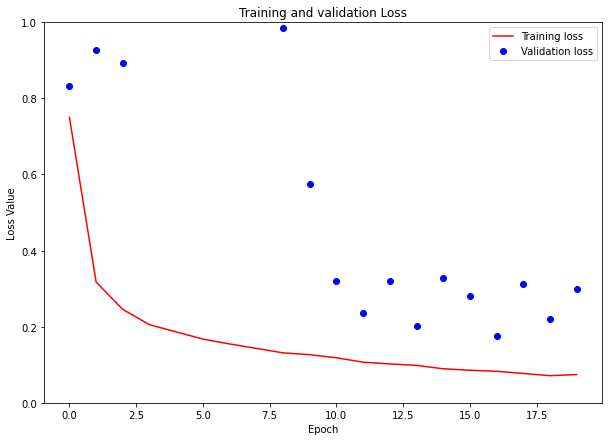

In [21]:
# Plot training and validation loss while training
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(10, 7))
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.savefig('Training and validation loss.jpg', dpi=500)
plt.show()

# **Model evaluation**

In this section, various evaluation metrics are calculated including the following:

* **Jaccard score**: It is defined as the **size of the intersection divided by the size of the union of two label sets**. It is used to compare set of predicted labels for a sample to the corresponding set of labels in y_true. It is therefore an appropriate measure for the segmentation task since it compares the pixels of the ematome that have the prediction and ground truth in common with the union of pixels from both. The closer it is to 1 the better. **In this project it is taken as the main measure.**

* **Dice score**: Measure similar to Jaccard, it is computed as two times the size of the overlap of the two segmentations divided by the total size of the two objects. The closer it is to 1 the better.

* **Pixel accuracy**: Denotes the percent of pixels that are accurately classified in the image. This metric calculates the ratio between the amount of adequately classified pixels and the total number of pixels in the image. (Correct predictions / Number of predictions).

* **Sensitivity**: It indicates how many of the positive intances are correctly classsified as possitive. **It is therefore vitally important to know what percentage of melanoma cells have been correctly classified as melanoma. This measure is of vital importance in medical applications as no cancer cells should be left untreated. In other cases it is equally important as it is better to diagnose someone with cancer and have it be incorrect than to diagnose someone without cancer and not treat them.** True positive rate (True positives / True positives + False negatives). (Recall).

* **Specificity**: In a similar way as the sensitivity it indicates how many of the negative instances are correctly classified as negative. True negative rate (True negative / True negative + False positives).

* **ROC Curve**: An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters: True Positive Rate and False Positive Rate.An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. An interesting measure derived from this curve is the AUC, standing for Area Under the ROC Curve.


In [22]:
test_gen = LesionSegmentation(batch_size, img_size, test_input_img_paths, test_target_img_paths, False)
test_preds = model.predict(test_gen)

jaccard_scores = []
dice_scores = []
pixel_accuracy = []
sensitivity = []
specitivity = []
 
predictions_formatted = []
ground_truth_formatted = []
    
for i in range(0, len(test_preds)):
    # Adapt prediction and ground truth
    prediction = np.argmax(test_preds[i], axis=-1)
    prediction = np.expand_dims(prediction, axis=-1)
    predictions_formatted.append(prediction.flatten())
    ground_truth = np.array(load_img(test_target_img_paths[i], target_size=img_size, color_mode="grayscale"))
    ground_truth = (np.expand_dims(ground_truth, 2)/255).astype(int)
    ground_truth_formatted.append(ground_truth.flatten())
    number_of_pixels = img_size[0]*img_size[1]    
    
    # Get Jaccard score
    intersection = np.logical_and(ground_truth, prediction)
    union = np.logical_or(ground_truth, prediction)
    jaccard_scores.append(np.sum(intersection) / np.sum(union))  
    
    # Get Dice coefficient
    intersection = np.sum(ground_truth.flatten() == prediction.flatten())
    dice_scores.append((2 * np.sum(intersection) ) / (number_of_pixels + number_of_pixels))
    
    # Pixel-based metrics
    equal_pixels = 0
    number_of_true_positives = 0
    number_of_true_negatives = 0
    number_of_false_negatives = 0
    number_of_false_positives = 0
    
    for row in range(len(ground_truth)):
        for column in range(len(ground_truth[row])):
            
            if prediction[row][column] == ground_truth[row][column]:
                equal_pixels += 1
                
            if ground_truth[row][column] == 1 and prediction[row][column] == ground_truth[row][column]:
                number_of_true_positives += 1
                
            if ground_truth[row][column] == 0 and prediction[row][column] == ground_truth[row][column]:
                number_of_true_negatives +=1
            
            if prediction[row][column] == 1 and prediction[row][column] != ground_truth[row][column]:
                number_of_false_positives += 1
            
            if prediction[row][column] == 0 and prediction[row][column] != ground_truth[row][column]:
                number_of_false_negatives += 1
                
    # Pixel accuracy: (Correct predictions / Number of predictions)      
    pixel_accuracy.append(equal_pixels / number_of_pixels)
    # Sensitivity - Recall: True positive rate (True positives / True positives + False negatives). How many of the positives are correct
    try:sensitivity.append(number_of_true_positives / (number_of_true_positives + number_of_false_negatives))
    except:sensitivity.append(0)
    # Specitivity - True negative rate (True negative / True negative + False positives). How many of the negatives are correct
    try: specitivity.append(number_of_true_negatives / (number_of_true_negatives + number_of_false_positives))
    except: specitivity.append(0)
        
print(f"Jaccard Score: {np.mean(jaccard_scores)} \nDice Score: {np.mean(dice_scores)} \nPixel accuracy: {np.mean(pixel_accuracy)} \nSensitivity: {np.mean(sensitivity)} \nSpecificity: {np.mean(specitivity)}")

Jaccard Score: 0.8146659126600477 
Dice Score: 0.950408935546875 
Pixel accuracy: 0.950408935546875 
Sensitivity: 0.9194613964036656 
Specificity: 0.970427234552992


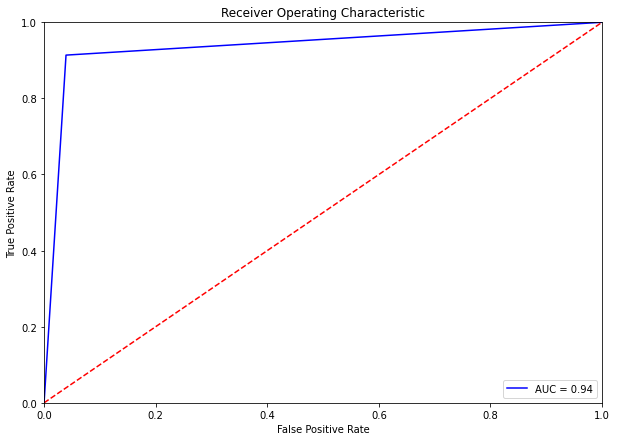

In [23]:
# Get and plot ROC curve
fpr, tpr, threshold = metrics.roc_curve(np.array(predictions_formatted).flatten(), np.array(ground_truth_formatted).flatten())
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC_curve.jpg', dpi=500)
plt.show()

# **Model predictions**

This section generates predictions for some test images of the dataset and displays them graphically in order to be able to evaluate the network predictions in a more visual way.

In [24]:
def adapt_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(test_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    return img

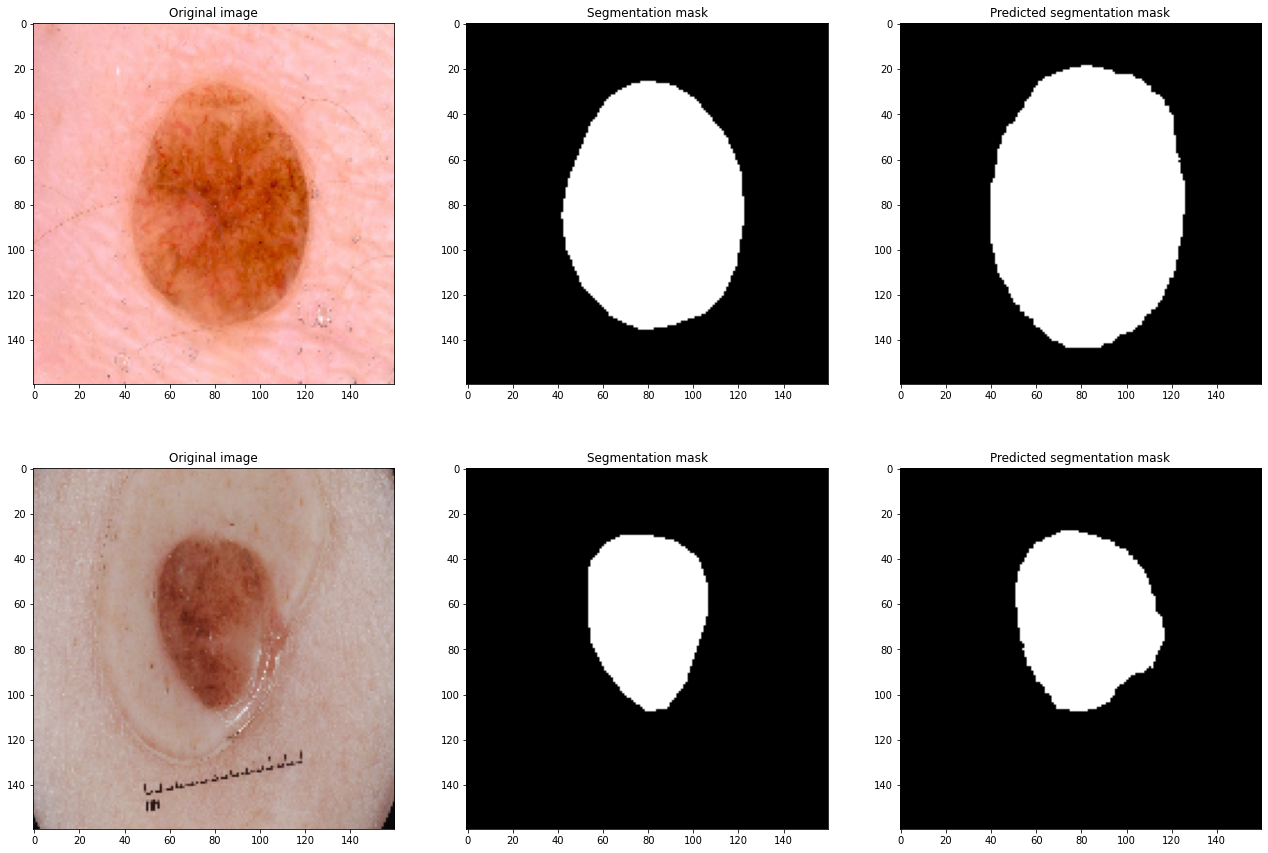

In [25]:
# Cetting values to rows and column variables
rows = 2
columns = 3

# Create figure
fig, axs = plt.subplots(nrows=rows, ncols=columns, figsize=(22, 15))
row = 0

for i in [1, 7]:
    
    column = 0
    
    # Plot images
    axs[row, column].imshow(load_img(test_input_img_paths[i], target_size=img_size))
    axs[row, column].set_title("Original image")
    column+=1
    
    axs[row, column].imshow(load_img(test_target_img_paths[i],  target_size=img_size), cmap='gray')
    axs[row, column].set_title("Segmentation mask")
    column+=1
    
    axs[row, column].imshow(adapt_mask(i), cmap='gray')
    axs[row, column].set_title("Predicted segmentation mask")
    column+=1
    row+=1

plt.savefig('Predicted segmantation masks.jpg', dpi=300)

# **Results, critical commentary and discussion**

Throughout this notebook, a U-Net Xception-style network has been implemented with data augmentation and different metrics that allow to know in depth the quality of the proposed solution. The use of the different parameters is not the result of chance, but of a process of rigorous experimentation and problem solving. Thus, the effect of the following parameters on the network has been tested. *(All of the following metrics shown are Jaccard Score)*.

* **Batch size**: The number of samples processed before the model updates its parameters. Thus, the smaller the batch size the faster convergence to optimal minima, since the model starts learning before having to see all the train data. It should be a “point” between 1 and the whole dataset batch size, that leads to the best generalization. Usually, a lower batch size will lead to better test accuracy, however, it will also cause more instabilities in validation depending on how noisy the data are in every batch. **In this notebook, the values tested were 4 - 6 - 16 - 32, obtaining the best overall result with 16.**

* **Data augmentation.** As stated previosly, the data augmentation process has been solved by a function tailored to the task at hand. The reason for this choice was the impossibility of using Tensorflow's own generator function. This is because the Tensorflow options do not take into account that the same transformation must be applied to both melanoma images and segmentations. Otherwise, it is not possible for the network to learn the task properly. **However, the use of data augmentation has not improved the network's performance. This may be due to the fact that the custom function is not good enough because, for example, it is too aggressive. Thus, when generating the variations of the existing data, the network does not generalise the problem properly and the predictions in tests are much worse. Therefore, we have tried to modify the data augmentation function without obtaining the desired results**. (without data augmentation: 0,763 - data augmentation: 0,819)

* **Loss function**: As part of the optimization algorithm, the error for the current state of the model must be estimated repeatedly. This requires the choice of an error function of the model so that the weights can be updated to reduce the loss on the next evaluation. **In this notebook we use sparse categorical crossentropy and binary crossentropy**. The choice for spare is due to the fact that the "sparse" version of categorical_crossentropy handles integers as target data. Cross-entropy will calculate a score that summarizes the average difference between the actual and predicted probabilitydistributions for all classes in the problem. The score is minimized and a perfect cross-entropy value is 0. **The choosen value for the network is sparse categorical crossentropy** since it optains better score (sparse: 0,819 - binary: 0,72).

* **Optimizer**: **It determines how the network will be updated based on the loss function**. Optimizers are algorithms used to change the attributes of the neural network such as weights and learning rate in order to reduce the losses. The choosen one based on experimentation on the problem is **RMSProp**, nevertheless, the ones tested in this notebook are 

    * **SGD** - (0,721) - Stochastic gradient descent. Classic method.
    * **RMSProp** - (0,819) - Root Mean Square Propagation maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing). This means the algorithm does well on noisy problems.
    * **Adam** - (0,771) - Extension of stochastic gradient descent. The name Adam is derived from adaptive moment estimation.  Empirical results demonstrate that Adam works well in practice and compares favourably to other stochastic optimization methods.

* **Learning rate**: Learning rate determines the step size at each iteration while moving toward a minimum of a loss function. A value of 0,001 is choosen in this notebook.

* **Number of epochs**: Number of complete passes of the training data through the network. With the choosen set of parameters 20 achieve the best overall result.


**Thus, in the end, the parameters that obtain the best results are: 16 Batch size, 0,001 Learning rate, RMSProp optimizer, Sparse categorical crossentropy loss, No data augmentation and an image size of 160x160. The best result obtained is 0,819.**

**This result is considered to be very good considering that in the challenge ranking it would have been placed in position 4 as can be observed from: https://challenge.isic-archive.com/leaderboards/2016/**